*** 
# **Licence Informatique 3ème année**,
***
Traitement de signaux ECG
***

In [1]:
# Imports necessaires

from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


***
# 1) Prétraitement des données
***
## Lecture de fichier à l'aide de *scipy.io*

In [2]:

# Charger le fichier
data = loadmat('ecg_dataset.mat')

***
# 2) Normaliser les données
***
## normaliser pour un mailleur traitement avec *TensorFlow*

In [3]:
# Recuperer X (les signaux ECG) et y (les classes : 0, 1 ou 2)
X = data['X']
y = data['y'].flatten()

# Séparer les signaux normaux (classe 0) pour entrainer le modèle d'auto-encodeur à recontruire uniquement les signaux normaux
X_good = X[y == 0]

In [4]:
# normalisation des données
def normalize_data(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

X_good_normalized = normalize_data(X_good)

# diviser les données en ensembles d'entrainement et de validation
X_train, X_val = train_test_split(X_good_normalized, test_size=0.2, random_state=42)
# reshape training data to (n_samples, 146, 1)
X_train = X_train[..., np.newaxis]
X_val   = X_val[...,   np.newaxis]

In [5]:
from tensorflow import keras
from keras import layers, Model

def create_improved_autoencoder(input_shape=(146, 1)):
    inputs = layers.Input(shape=input_shape)
    
    # ----- ENCODEUR avec Batch Normalization et Dropout -----
    x = layers.Conv1D(64, 7, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv1D(32, 7, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv1D(16, 7, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    encoded = layers.MaxPooling1D(2, padding='same', name="encoded")(x)
    
    # ----- DÉCODEUR -----
    x = layers.Conv1D(16, 7, activation='relu', padding='same')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling1D(2)(x)
    
    x = layers.Conv1D(32, 7, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling1D(2)(x)
    
    x = layers.Conv1D(64, 7, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling1D(2)(x)
    
    decoded = layers.Conv1D(1, 7, activation='linear', padding='same')(x)
    decoded = layers.Cropping1D((3, 3))(decoded)
    
    autoencoder = Model(inputs, decoded)
    return autoencoder


entrainement de l'autoencodeur

In [8]:
autoencoder = create_improved_autoencoder(X_train.shape[1:])
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    X_train, X_train,        # entrée = sortie
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.5628 - val_loss: 0.8668
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2852 - val_loss: 0.7559
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2415 - val_loss: 0.8707
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.2222 - val_loss: 0.7629
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.2645 - val_loss: 0.5416
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1762 - val_loss: 0.5576
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.2070 - val_loss: 0.3534
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1781 - val_loss: 0.2257
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1656 - val_loss: 0.1391
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1727 - val_loss: 0.2235
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1495 - val_loss: 0.2051
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


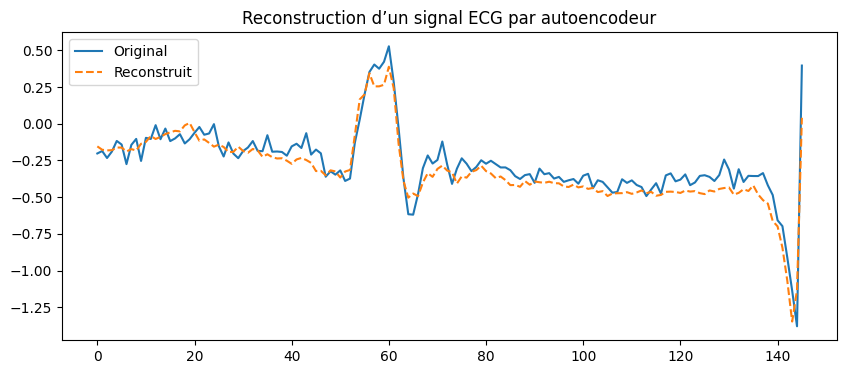

In [9]:
# Visualiser la reconstruction d’un signal ECG normal à partir de l’ensemble de validation

decoded_signals = autoencoder.predict(X_val)

i = 0
plt.figure(figsize=(10,4))
plt.plot(X_val[i].squeeze(), label='Original')
plt.plot(decoded_signals[i].squeeze(), label='Reconstruit', linestyle='dashed')
plt.legend()
plt.title("Reconstruction d’un signal ECG par autoencodeur")
plt.show()


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Seuil de détection d'anomalies : 0.2092975544034017


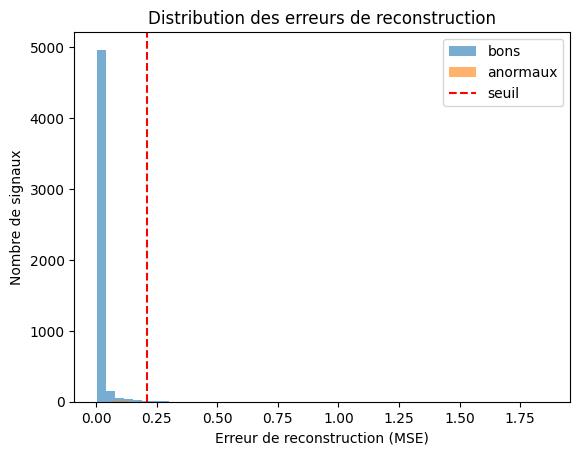

In [10]:
# Detection d'anomalies en utilisant l'erreur de reconstruction
# Normaliser les signaux avant la prédiction (fonction normalize_data définie précédemment)
X_norm = normalize_data(X)

# ajouter la dimension canal attendue par le modèle (146, 1)
X_input = X_norm[..., np.newaxis]

# prédiction
reconstructions = autoencoder.predict(X_input)

# enlever la dimension canal pour calculer le MSE
reconstructions = reconstructions.squeeze()  # shape (n_samples, 146)

mse = np.mean(np.square(X_norm - reconstructions), axis=1)

threshold = np.mean(mse[y == 0]) + 3 * np.std(mse[y == 0])
anomalies = mse > threshold
print(f"Seuil de détection d'anomalies : {threshold}")

plt.hist(mse[y==0], bins=50, alpha=0.6, label='bons')
plt.hist(mse[y!=0], bins=50, alpha=0.6, label='anormaux')
plt.axvline(threshold, color='r', linestyle='--', label='seuil')
plt.legend()
plt.xlabel("Erreur de reconstruction (MSE)")
plt.ylabel("Nombre de signaux")
plt.title("Distribution des erreurs de reconstruction")
plt.show()
